In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
import re

# Data Preparation

## Creating a list of punctuations to be removed

In [2]:
chr_list = """!#%^&*()+=-_{}[]\|;:,"'<.>/?~`"""
patt = """"""
for i in chr_list:
    patt += "\\" + i + "|"

## Normalizing the non-spam (list 1) emails

In [3]:
content_ham = []
for email in listdir('easy_ham/'):
    file = open('easy_ham//' + email, mode='r', errors='ignore')
    
    dat = file.read().lower() #lower-casing the characters
    file.close()
    
    d1 = re.sub(patt[:-1], "", dat) #removing the punctuations
    d1 = d1.replace('$','dollar') #replacing $ with the word "dollar"
    d2 = d1.split()
    for i in range(len(d2)):
        if d2[i].isdigit(): 
            d2[i] = 'number' #changing numbers into the word "number"
        elif '@' in d2[i]: 
            d2[i] = 'emailaddr' #changing email addresses into the word "emailaddr"
        elif 'http' in d2[i]:
            d2[i] = 'urladdr' #changing url addresses into the word "urladdr"
    content_ham.append(" ".join(d2))
    

## Normalizing the non-spam (list 2) emails

In [4]:
content_ham_hard = []
for email in listdir('hard_ham/'):
    file = open('hard_ham//' + email, mode='r', errors='ignore')
    
    dat = file.read().lower() #lower-casing the characters
    file.close()
    
    d1 = re.sub(patt[:-1], "", dat) #removing the punctuations
    d1 = d1.replace('$','dollar') #replacing $ with the word "dollar"
    d2 = d1.split()
    for i in range(len(d2)):
        if d2[i].isdigit():
            d2[i] = 'number' #changing numbers into the word "number"
        elif '@' in d2[i]:
            d2[i] = 'emailaddr' #changing email addresses into the word "emailaddr"
        elif 'http' in d2[i]:
            d2[i] = 'urladdr' #changing url addresses into the word "urladdr"
    content_ham_hard.append(" ".join(d2))
    

## Normalizing the spam emails

In [5]:
content_spam = []
for email in listdir('spam/'):
    file = open('spam//' + email, mode='r', errors='ignore')
    
    dat = file.read().lower() #lower-casing the characters
    file.close()
    
    d1 = re.sub(patt[:-1], "", dat) #removing the punctuations
    d1 = d1.replace('$','dollar') #replacing $ with the word "dollar"
    d2 = d1.split()
    for i in range(len(d2)):
        if d2[i].isdigit():
            d2[i] = 'number' #changing numbers into the word "number"
        elif '@' in d2[i]:
            d2[i] = 'emailaddr' #changing email addresses into the word "emailaddr"
        elif 'http' in d2[i]:
            d2[i] = 'urladdr' #changing url addresses into the word "urladdr"
    content_spam.append(" ".join(d2))
    

## Combining non-spam and spam content together as well as their labels 

In [6]:
contents = content_ham + content_ham_hard + content_spam
labels = np.vstack([np.zeros((len(content_ham),1))
                    ,np.zeros((len(content_ham_hard),1))
                    ,np.ones((len(content_spam),1))])
labels = labels.reshape(len(labels))

print(labels.shape)

(3302,)


## Tokenizing

In [7]:
# creating a sparse matrix of token counts using single words in the emails
# 5% of tokens with highest and lowest frequencies in the content are ignored

vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word', min_df=0.05, max_df=0.95 )
X = vectorizer.fit_transform(contents)

print(X.shape)

(3302, 564)


# Train and Test Example

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels)

# SVM classifier
svm_split = SVC(kernel='rbf', gamma='auto')
svm_split.fit(X_train, y_train)
svm_pred = svm_split.predict(X_test)

print('svm_split_report:',classification_report(y_test, svm_pred),'\n', sep='\n')


svm_split_report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       561
         1.0       0.98      0.92      0.95       100

    accuracy                           0.98       661
   macro avg       0.98      0.96      0.97       661
weighted avg       0.98      0.98      0.98       661





# Validation Curve

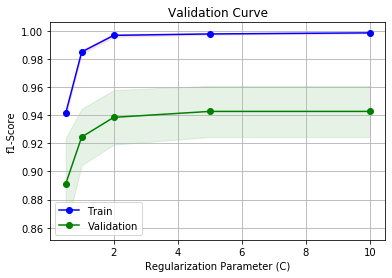

In [15]:
#here, in order to avoid overfitting or underfitting a range of regularization parameter C is being validated

from sklearn.model_selection import validation_curve

indices = np.arange(len(labels))
np.random.shuffle(indices)
X_val, y_val = X[indices], labels[indices] #shuffling the training examples

par_range = [0.5, 1, 2, 5, 10] #range of regularization parameter C in SVC

#training and validation
train_scores_valid_curve, valid_scores_valid_curve = validation_curve(
    SVC(kernel='rbf', gamma='auto'), X_val, y_val, 'C',par_range, cv=10 , scoring='f1')

train_scores_std = np.std(train_scores_valid_curve, axis=1)
valid_scores_std = np.std(valid_scores_valid_curve, axis=1)
train_scores_mean = np.mean(train_scores_valid_curve, axis=1)
valid_scores_mean = np.mean(valid_scores_valid_curve, axis=1)

plt.grid()

plt.fill_between(par_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(par_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(par_range, train_scores_mean, 'b-o',label = 'Train')
plt.plot(par_range, valid_scores_mean, 'g-o',label = 'Validation')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('f1-Score')
plt.title('Validation Curve')
plt.legend(loc='best')
plt.show()

In [16]:
np.std(valid_scores_valid_curve, axis=1)

array([0.03267693, 0.02009457, 0.01943206, 0.01824075, 0.01824075])

# Learning Curve

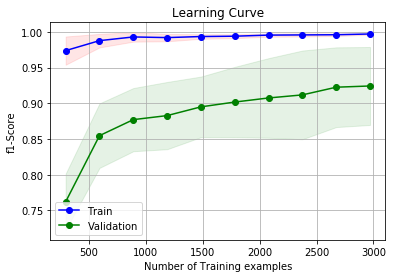

In [14]:
# here, we check the validation and training score of our estimator for varying numbers of training samples.

from sklearn.model_selection import learning_curve

train_sizes, train_scores_learn_curve, valid_scores_learn_curve = learning_curve(
    SVC(kernel='rbf', gamma='auto', C=2.0), X, labels, train_sizes=np.linspace(0.1, 1, 10), cv=10,
    scoring='f1', shuffle = True)

train_scores_std = np.std(train_scores_learn_curve, axis=1)
valid_scores_std = np.std(valid_scores_learn_curve, axis=1)
train_scores_mean = np.mean(train_scores_learn_curve, axis=1)
valid_scores_mean = np.mean(valid_scores_learn_curve, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")

plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'b-o',label = 'Train')
plt.plot(train_sizes, valid_scores_mean, 'g-o',label = 'Validation')

plt.xlabel('Number of Training examples')
plt.ylabel('f1-Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

# Cross Validation Score

In [11]:
# SVM classifier
svm_cv = SVC(C=2.0, kernel='rbf', gamma='auto')
svm_score_cv = cross_val_score(svm_cv, X, labels, cv=10, scoring='f1')

print('svm cross validation f1-score:',svm_score_cv,'\n', sep='\n')
print('svm cross validation mean f1-score:',np.mean(svm_score_cv),'\n', sep='\n')
print('svm cross validation std f1-score:',np.std(svm_score_cv),'\n', sep='\n')

svm cross validation score:
[0.93877551 0.9010989  0.95833333 0.94736842 0.97959184 0.94736842
 0.95833333 0.91304348 0.92473118 0.77419355]


svm cross validation mean score:
0.9242837966253272


svm cross validation std score:
0.05463030078743098




# Saving the trained SVM classifier for spam emails

In [17]:
# Here, we use all the dataset for training a SVM classifier and save it

import joblib

svm_out = SVC(C=2.0, kernel='rbf', gamma='auto')
svm_out.fit(X, labels)
joblib.dump(svm_out, 'spam_email_SVM_classifier.pkl')

['spam_email_SVM_classifier.pkl']